# KL Divergence

Machine learning involves approximating intractable probability distributions. 
One approach to approximating is to find a distribution that minimizes the [KL Divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) with the target distribution. For example, the approximating distributions could be normal distributions with different means and variances.

When KL Divergence is introduced in the context of machine learning, one point is that KL Divergence $KL(P \mid\mid Q)$ will select a different distribution than $KL(Q \mid\mid P)$. This blog post explores this by telling an optimizer (TensorFlow) to minimize the two KL Divergences. 

![](images/2018-12-27-comparison.png)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import entropy
import tensorflow as tf

from ipywidgets import interact

# helper functions you can skip over :D
SAVE = False
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)  

## KL Divergence equation for discrete distributions

Wikipedia gives the KL Divergence for discrete distributions as

$$KL(P \mid\mid Q) = \sum_i P_i \log \left(\frac{P_i}{Q_i}\right).$$

If $P_i$ = 0, then the $i^{th}$ term is 0. $KL$ is only defined if when $Q_i = 0$, then $P_i = 0$.

For example, we can have $P$ be the distribution we're trying approximate with $Q$. The KL Divergence will be big if $Q_i$ is close to 0 where $P_i$ is not close to 0. If $P_i$ is close to 0, $Q_i$ won't affect the KL Divergence as much.

### An example target distribution and two example approximate distributions

Let's plot a few examples!

For this first example, I'll make $P$ based on the distribution $\beta(2, 5)$. This is interesting because $P_i$ is 0 outside of the domain of 0 to 1. I'll use $Q$s that are based on a normal distribution, so $Q$ is never 0.
I highlight the area where $P_i > 0$.

#### Aside: Discrete vs Continuous

In order to make cool-looking graphs, I'm using discrete distributions that are based on continuous distributions, like the normal distribution. For example, below I start with 200 evenly-spaced numbers between -1 and 2. I compute the value of the PDF for those numbers. Then I normalize the vector so the 200 numbers add to 1 and it becomes a discrete distribution.

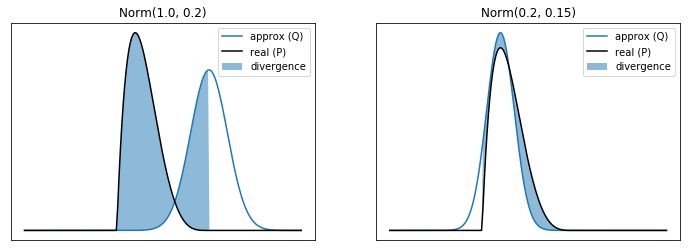

In [2]:
xgrid = np.linspace(-1, 2, 200)

real_dist = beta(2, 5).pdf(xgrid)
real_dist /= np.sum(real_dist, axis=0)

approx_dist_1 = norm(1, 0.2).pdf(xgrid)
approx_dist_1 /= np.sum(approx_dist_1, axis=0)

approx_dist_2 = norm(0.2, 0.15).pdf(xgrid)
approx_dist_2 /= np.sum(approx_dist_2, axis=0)

def plot_real_and_approx_dist(ax, real_dist, approx_dist):
    ax.plot(xgrid, approx_dist, label='approx (Q)')
    ax.plot(xgrid, real_dist, color='k', label='real (P)')
    ax.fill_between(xgrid, np.where(real_dist > 0, approx_dist, 0), real_dist, alpha=0.5, label='divergence')
    ax.legend()
    hide_ticks(ax)
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_real_and_approx_dist(axs[0], real_dist, approx_dist_1)
axs[0].set_title("Norm(1.0, 0.2)")
plot_real_and_approx_dist(axs[1], real_dist, approx_dist_2)
axs[1].set_title("Norm(0.2, 0.15)")

maybe_save_plot('2018-12-27-examples')
plt.show()

### Computing KL Divergence

I can translate the formula to `numpy`, then compute the KL Divergence between the two approximating distributions and the target distribution.

As expected, the KL Divergence is higher for the approximating distribution based on Norm(1, 0.2) than the distribution based on Norm(0.2, 0.15).

In [3]:
def kl_divergence(p, q):
    # Computes KL(p || q). Note that outside of this function, P is the target distribution
    # and Q is the approximating distribution. Inside of this function, P is just the
    # first argument and Q is the second.
    # I inefficiently iterate through all of the q and p values to
    # only compute the log when p_i > 0.
    terms = [
        p_i * np.log(p_i/q_i) if p_i > 0 else 0
        for q_i, p_i in zip(q, p)
    ]
    return np.sum(terms, axis=0)


print("Q = Norm(1.0, 0.20) \tKL(P || Q) = {:.6f}".format(
    kl_divergence(p=real_dist, q=approx_dist_1), 
))

print("Q = Norm(0.2, 0.15) \tKL(P || Q) = {:.6f}".format(
    kl_divergence(p=real_dist, q=approx_dist_2)
))

Q = Norm(1.0, 0.20) 	KL(P || Q) = 6.491177
Q = Norm(0.2, 0.15) 	KL(P || Q) = 0.236206


    Q = Norm(1.0, 0.20) 	KL(P || Q) = 6.491177
    Q = Norm(0.2, 0.15) 	KL(P || Q) = 0.236206

#### Aside: Verifying the implementation

`scipy`'s [`entropy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) computes KL Divergence when called with two parameters. I can verify my implementation produces similar results.

In [4]:
assert np.isclose(
    kl_divergence(p=real_dist, q=approx_dist_1),
    entropy(pk=real_dist, qk=approx_dist_1)
)

assert np.isclose(
    kl_divergence(p=real_dist, q=approx_dist_2),
    entropy(pk=real_dist, qk=approx_dist_2)
)

#### Aside: Interactive

Before I implement something that minimizes the divergence automatically, I can use [ipywidgets](/2018/05/04/ipywidgets.html) to interactively try different distributions.

In [5]:
def plot_and_compute_kl_divergence_for_real_dist(xgrid, real_dist):
    
    def plot_and_compute_kl_divergence(mu, var):
        fig, ax = plt.subplots()
            
        approx_dist = norm(mu, var).pdf(xgrid)
        approx_dist /= np.sum(approx_dist, axis=0)
        
        print(
            "Q = Norm({:.2f}, {:.2f})\nKL(P || Q) = {:.6f}\nKL(Q || P) = {:.6f}".format(
                mu,
                var,
                entropy(pk=real_dist, qk=approx_dist),
                entropy(pk=approx_dist, qk=real_dist),
            )
        )
    
        ax.plot(xgrid, approx_dist, label='approx')
        ax.plot(xgrid, real_dist, color='k', label='real')
        ax.fill_between(xgrid, np.where(real_dist > 0, approx_dist, 0), real_dist, alpha=0.5, label='divergence')
    
        hide_ticks(ax)
        ax.legend()
        plt.show()
    return plot_and_compute_kl_divergence
    
interact(plot_and_compute_kl_divergence_for_real_dist(xgrid, real_dist), mu=(-0.5, 1.5), var=(0, 0.6, 0.05))

interactive(children=(FloatSlider(value=0.5, description='mu', max=1.5, min=-0.5), FloatSlider(value=0.25, des…

<function __main__.plot_and_compute_kl_divergence_for_real_dist.<locals>.plot_and_compute_kl_divergence(mu, var)>

![](images/2018-12-27-divergence-ex.png)

## Multimodal Example

One point with KL Divergence is that finding a $Q$ that minimizes $KL(Q \mid\mid P)$ is different than finding a $Q$ that minimizes $KL(P \mid\mid Q)$. One way to illustrate the difference is to look at a multimodal distribution.

In [6]:
xgrid_multimodal = np.arange(-4, 4, 0.05)

real_dist_multimodal = norm(2, 0.3).pdf(xgrid_multimodal) + norm(-3, 0.3).pdf(xgrid_multimodal)
real_dist_multimodal /= np.sum(real_dist_multimodal, axis=0)

interact(
    plot_and_compute_kl_divergence_for_real_dist(xgrid_multimodal, real_dist_multimodal), 
    mu=(-4, 4, 0.5), 
    var=(0.1, 10.0, 0.1)
)

interactive(children=(FloatSlider(value=0.0, description='mu', max=4.0, min=-4.0, step=0.5), FloatSlider(value…

<function __main__.plot_and_compute_kl_divergence_for_real_dist.<locals>.plot_and_compute_kl_divergence(mu, var)>

|||
|-|-|
| ![](images/2018-12-27-divergence-ex-bimodal-1.png) | ![](images/2018-12-27-divergence-ex-bimodal-2.png) |

### Minimizing KL Divergence

I can implement KL Divergence in TensorFlow and then use gradient descent to find an approximating distribution $Q = Norm(\mu, \sigma^2)$ that minimizes the KL Divergence.

In [7]:
def optimize_kl_divergence(bin_location, real_dist, iterations=100, learning_rate=0.05, find_kl_q_p=True):
    D = 1  # This is only supported for 1-dimensional distributions.
        
    # Placeholder for the true distribution
    real_dist_placeholder = tf.placeholder(tf.float64, shape=(D, None))
    
    # Set up variables for guess. This is what we'll learn.
    approx_mu = tf.Variable(np.zeros(D))
    approx_var = tf.Variable(np.eye(D))
    
    # Convert mu and var into a discrete distribution
    # We're normalizing it anyway, so we don't need the scaling coefficient
    eq = tf.exp(-tf.square(bin_location - approx_mu) / (2 * approx_var))
    approx_dist_op = eq / tf.reduce_sum(eq)
    
    # Rewrite KL Divergence for TensorFlow
    def tf_kl_divergence(q, p): 
        # This will give warnings because we're computing the log even when 
        # p is 0. But it uses values from the 0 array in that case.
        terms = tf.where(p == 0, tf.zeros(real_dist.shape, tf.float64), p * tf.log(p/q))
        return tf.reduce_sum(terms)
    
    # This let's us switch whether we want the real distribution as Q or P.
    if find_kl_q_p:
        kl_div = tf_kl_divergence(p=approx_dist_op, q=real_dist_placeholder)
    else:
        kl_div = tf_kl_divergence(p=real_dist_placeholder, q=approx_dist_op)
    
    loss_op = kl_div
    
    # Learning rate is finicky! 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss_op)
        
    # Now find an optimal mu and var that minimizes the KL divergence.
    kl_divs = []
    approx_dists = []
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        for i in range(iterations):
            approx_dist, loss, _, mu, var = sess.run(
                [approx_dist_op, loss_op, train_op, approx_mu, approx_var],
                {real_dist_placeholder: real_dist}
            )
        
            kl_divs.append(loss)
            approx_dists.append(approx_dist)            
        
    return kl_divs, approx_dists, mu[0], var[0][0]

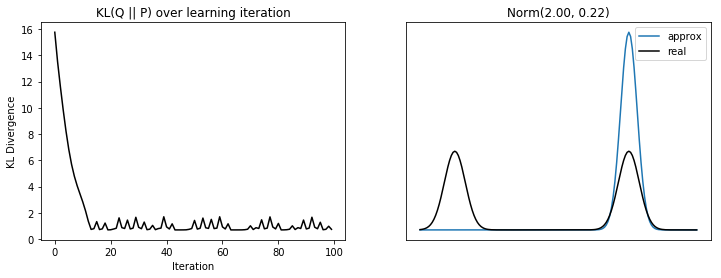

In [8]:
kl_divs, approx_dists_multimodal, mu, var = optimize_kl_divergence(xgrid_multimodal, real_dist_multimodal.reshape(1, -1))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(kl_divs, 'k')
axs[0].set_title('KL(Q || P) over learning iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('KL Divergence')

axs[1].plot(xgrid_multimodal, approx_dists_multimodal[-1][0], label='approx')
axs[1].plot(xgrid_multimodal, real_dist_multimodal, color='k', label='real')
axs[1].set_title('Norm({:.02f}, {:.02f})'.format(mu, var))
axs[1].legend()
hide_ticks(axs[1])

maybe_save_plot('2018-12-27-minimizing')
plt.show()

It's also neat to plot how the distribution shifts as it improves!

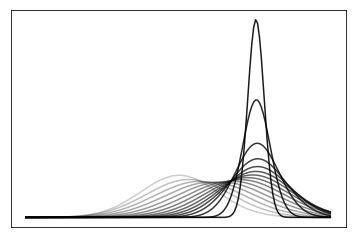

In [9]:
fig, ax = plt.subplots()

for i, approx_dist in enumerate(approx_dists_multimodal):
    if i < 15:
        ax.plot(xgrid_multimodal, approx_dist[0], color='k', alpha=0.2 + i/20)
hide_ticks(ax)
maybe_save_plot('2018-12-27-learning')
plt.show()

### Comparison of KL(Q || P) to KL(P || Q) 

Finally, I can compare the $Q$ that minimizes $KL(Q \mid\mid P)$ to the one that minimizes $KL(P \mid\mid Q)$.

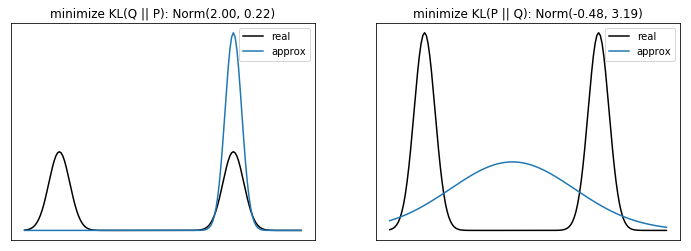

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

_, approx_dists_multimodal, mu, var = optimize_kl_divergence(
    xgrid_multimodal, 
    real_dist_multimodal.reshape(1, -1)
)
axs[0].plot(xgrid_multimodal, real_dist_multimodal, color='k', label='real')    
axs[0].plot(xgrid_multimodal, approx_dists_multimodal[-1][0], label='approx')
axs[0].set_title('minimize KL(Q || P): Norm({:.02f}, {:.02f})'.format(mu, var))
axs[0].legend()
hide_ticks(axs[0])

_, approx_dists_multimodal, mu, var = optimize_kl_divergence(
    xgrid_multimodal, 
    real_dist_multimodal.reshape(1, -1), 
    find_kl_q_p=False
)
axs[1].plot(xgrid_multimodal, real_dist_multimodal, color='k', label='real')    
axs[1].plot(xgrid_multimodal, approx_dists_multimodal[-1][0], label='approx')
axs[1].set_title('minimize KL(P || Q): Norm({:.02f}, {:.02f})'.format(mu, var))
axs[1].legend()
hide_ticks(axs[1])

maybe_save_plot('2018-12-27-comparison')
plt.show()

## See Also

 - Chapter 10 of Bishop's PRML talks about Variational Inference and has examples using bimodal distributions over two dimensions.
 - Another example of dealing with difficult distributions is using [Gibbs Sampling](/2018/05/09/gibbs-sampling.html)!
 - KL Divergence is used in [Variational Methods](https://en.wikipedia.org/wiki/Calculus_of_variations) like that used in [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), which is similar to [Expectation-Maximization](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm#Relation_to_variational_Bayes_methods).